In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats

In [65]:
# GENERATE SINGLE DATASET
num_users = 5000
num_experiments = 10000

sessions_skew = 0.5 # controls variance in views per user. higher = more variance
beta_size = 1000 # controls variance in conversion. higher = less variance
avg_conversion_rate = 0.2

sessions = np.exp(scipy.stats.norm(1, sessions_skew).rvs(num_users)).astype(np.int) + 1

a = avg_conversion_rate*beta_size
b = beta_size - avg_conversion_rate*beta_size
conversion_rates = np.random.beta(a, b, size=num_users)

orders = np.random.binomial(sessions, conversion_rates, size=num_users)

In [55]:
# ASSIGN USERS TO TEST & CONTROL
assignments = np.random.choice(num_users, num_users, replace=False)
control_idxs = assignments[0:int(num_users/2)]
treatment_idxs = assignments[int(num_users/2):]

sessions_control = sessions[control_idxs]
sessions_treatment = sessions[treatment_idxs]

orders_control = orders[control_idxs]
orders_treatment = orders[treatment_idxs]

In [56]:
# CALCULATE OBSERVED DIFFERENCE IN SESSION CONVERSION RATES
observed_diff = (
    orders_treatment.sum()/sessions_treatment.sum()
    -
    orders_control.sum()/sessions_control.sum()
)

print(
    f"Treatment is {observed_diff*100*100:0.0f} bps "
    f"{'higher' if observed_diff > 0 else 'lower'} than control"
)

Treatment is -133 bps lower than control


In [203]:
# REGULAR BOOTSTRAP

# under the null hypothesis we assume that all observations came from the same distribution
# therefore we randomly split users between test & control, regardless of their original assignment
# calculate difference in conversion rate for each bootstrap
# p-value is how often our actual observed difference from experiment was greater than bootstrapped differences

num_bootstraps = 5000

bs_observed_diffs = []
for x in range(0, num_bootstraps):

    bs_assignments = np.random.choice(num_users, num_users, replace=True)
    bs_control_idxs = bs_assignments[0:int(num_users/2)]
    bs_treatment_idxs = bs_assignments[int(num_users/2):]

    bs_sessions_control = sessions[bs_control_idxs]
    bs_sessions_treatment = sessions[bs_treatment_idxs]
    bs_orders_control = orders[bs_control_idxs]
    bs_orders_treatment = orders[bs_treatment_idxs]

    bs_observed_diffs.append(
        bs_orders_treatment.sum()/bs_sessions_treatment.sum()
        -
        bs_orders_control.sum()/bs_sessions_control.sum()
    )
    
p_value = 1 - (np.abs(observed_diff) > bs_observed_diffs).sum() / num_bootstraps
p_value

0.014399999999999968

In [204]:
# BOOTSTRAP VECTORIZED VERSION
num_bootstraps = 5000

bs_orders = np.tile(orders, (num_bootstraps, 1))
bs_sessions = np.tile(sessions, (num_bootstraps, 1))
assignment_idxs = (
    np.random.choice(bs_orders.shape[1], bs_orders.shape[1]*bs_orders.shape[0], replace=True)
    .reshape(bs_orders.shape)
)
bs_orders_shuffled = np.take_along_axis(bs_orders, assignment_idxs, axis=1)
bs_sessions_shuffled = np.take_along_axis(bs_sessions, assignment_idxs, axis=1)
    
group_size = int(bs_orders.shape[1]/2)
bs_observed_diffs = (
    bs_orders_shuffled[:, :group_size].sum(axis=1)/bs_sessions_shuffled[:, :group_size].sum(axis=1)
    -
    bs_orders_shuffled[:, group_size:].sum(axis=1)/bs_sessions_shuffled[:, group_size:].sum(axis=1)
)
    
p_value = 1 - (np.abs(observed_diff) > bs_observed_diffs).sum() / num_bootstraps
p_value

0.014399999999999968

# Vectorized Bootstraps for many datasets

**[marnikitta's version](https://github.com/marnikitta/stattests/blob/master/stattests/tests.py#L44-L66)**
* he generates poisson distribution for a single bootstrap test (i.e. 2000 variations for the 5000 users)
* these same 2000 variations are applied across every "experiment"
* he does not shuffle users between test & control, just shuffles how many times each user appears in test & control

**general notes**
* if you are running experiments on the same dataset, you only need to generate the bootstrap distribution once, and can share across all exps.
    * I will be doing this for blog post since that is closer to what you would do with a real offline A/A test (i.e. on your sample dataset of real user's sessions/orders). 
* if you are generating a new dataset for each experiment, you need to generate the bootstrap distribution each time, but can share the same random assignment indexes. see example of this below 👇

In [148]:
# 3 experiments, 6 users, 4 bootstraps
num_bootstraps = 4
A = np.array([
    [0, 2, 0, 1, 3, 0],
    [2, 1, 1, 0, 0, 3],
    [4, 0, 1, 0, 0, 2]
])
print(A.shape)
A

(3, 6)


array([[0, 2, 0, 1, 3, 0],
       [2, 1, 1, 0, 0, 3],
       [4, 0, 1, 0, 0, 2]])

In [189]:
A_test = A[:,:3]
A_control = A[:,3:]
A_test

array([[0, 2, 0],
       [2, 1, 1],
       [4, 0, 1]])

In [191]:
A_test.mean(axis=1) - A_control.mean(axis=1)

array([-0.66666667,  0.33333333,  1.        ])

In [149]:
bs_A = np.array([A]*num_bootstraps)
bs_A

array([[[0, 2, 0, 1, 3, 0],
        [2, 1, 1, 0, 0, 3],
        [4, 0, 1, 0, 0, 2]],

       [[0, 2, 0, 1, 3, 0],
        [2, 1, 1, 0, 0, 3],
        [4, 0, 1, 0, 0, 2]],

       [[0, 2, 0, 1, 3, 0],
        [2, 1, 1, 0, 0, 3],
        [4, 0, 1, 0, 0, 2]],

       [[0, 2, 0, 1, 3, 0],
        [2, 1, 1, 0, 0, 3],
        [4, 0, 1, 0, 0, 2]]])

In [151]:
assignment_idxs = (
    np.random.choice(A.shape[1], A.shape[1]*num_bootstraps, replace=True)
    .reshape(num_bootstraps, A.shape[1])
)
# assignment_idxs = np.array([assignment_idxs]*num_bootstraps)
assignment_idxs

array([[0, 5, 0, 5, 4, 5],
       [0, 4, 0, 2, 2, 3],
       [5, 2, 5, 4, 5, 4],
       [5, 1, 0, 0, 3, 0]])

In [152]:
assignment_idxs = np.repeat(assignment_idxs, 3, axis=0).reshape(bs_A.shape)

In [184]:
assignment_idxs

array([[[0, 5, 0, 5, 4, 5],
        [0, 5, 0, 5, 4, 5],
        [0, 5, 0, 5, 4, 5]],

       [[0, 4, 0, 2, 2, 3],
        [0, 4, 0, 2, 2, 3],
        [0, 4, 0, 2, 2, 3]],

       [[5, 2, 5, 4, 5, 4],
        [5, 2, 5, 4, 5, 4],
        [5, 2, 5, 4, 5, 4]],

       [[5, 1, 0, 0, 3, 0],
        [5, 1, 0, 0, 3, 0],
        [5, 1, 0, 0, 3, 0]]])

In [169]:
bs_A_shuffled = np.take_along_axis(bs_A, assignment_idxs, axis=2)
bs_A_shuffled

array([[[0, 0, 0, 0, 3, 0],
        [2, 3, 2, 3, 0, 3],
        [4, 2, 4, 2, 0, 2]],

       [[0, 3, 0, 0, 0, 1],
        [2, 0, 2, 1, 1, 0],
        [4, 0, 4, 1, 1, 0]],

       [[0, 0, 0, 3, 0, 3],
        [3, 1, 3, 0, 3, 0],
        [2, 1, 2, 0, 2, 0]],

       [[0, 2, 0, 0, 1, 0],
        [3, 1, 2, 2, 0, 2],
        [2, 0, 4, 4, 0, 4]]])

In [162]:
bs_A_control = bs_A_shuffled[:,:,:int(A.shape[1]/2)]
bs_A_test = bs_A_shuffled[:,:,int(A.shape[1]/2):]
bs_A_control

array([[[0, 0, 0],
        [2, 3, 2],
        [4, 2, 4]],

       [[0, 3, 0],
        [2, 0, 2],
        [4, 0, 4]],

       [[0, 0, 0],
        [3, 1, 3],
        [2, 1, 2]],

       [[0, 2, 0],
        [3, 1, 2],
        [2, 0, 4]]])

In [183]:
bs_A_test.mean(axis=2) - bs_A_control.mean(axis=2)

array([[ 1.        , -0.33333333, -2.        ],
       [-0.66666667, -0.66666667, -2.        ],
       [ 2.        , -1.33333333, -1.        ],
       [-0.33333333, -0.66666667,  0.66666667]])

In [192]:
A_test.mean(axis=1) - A_control.mean(axis=1)

array([-0.66666667,  0.33333333,  1.        ])

# Generate Data & Get ExP Results

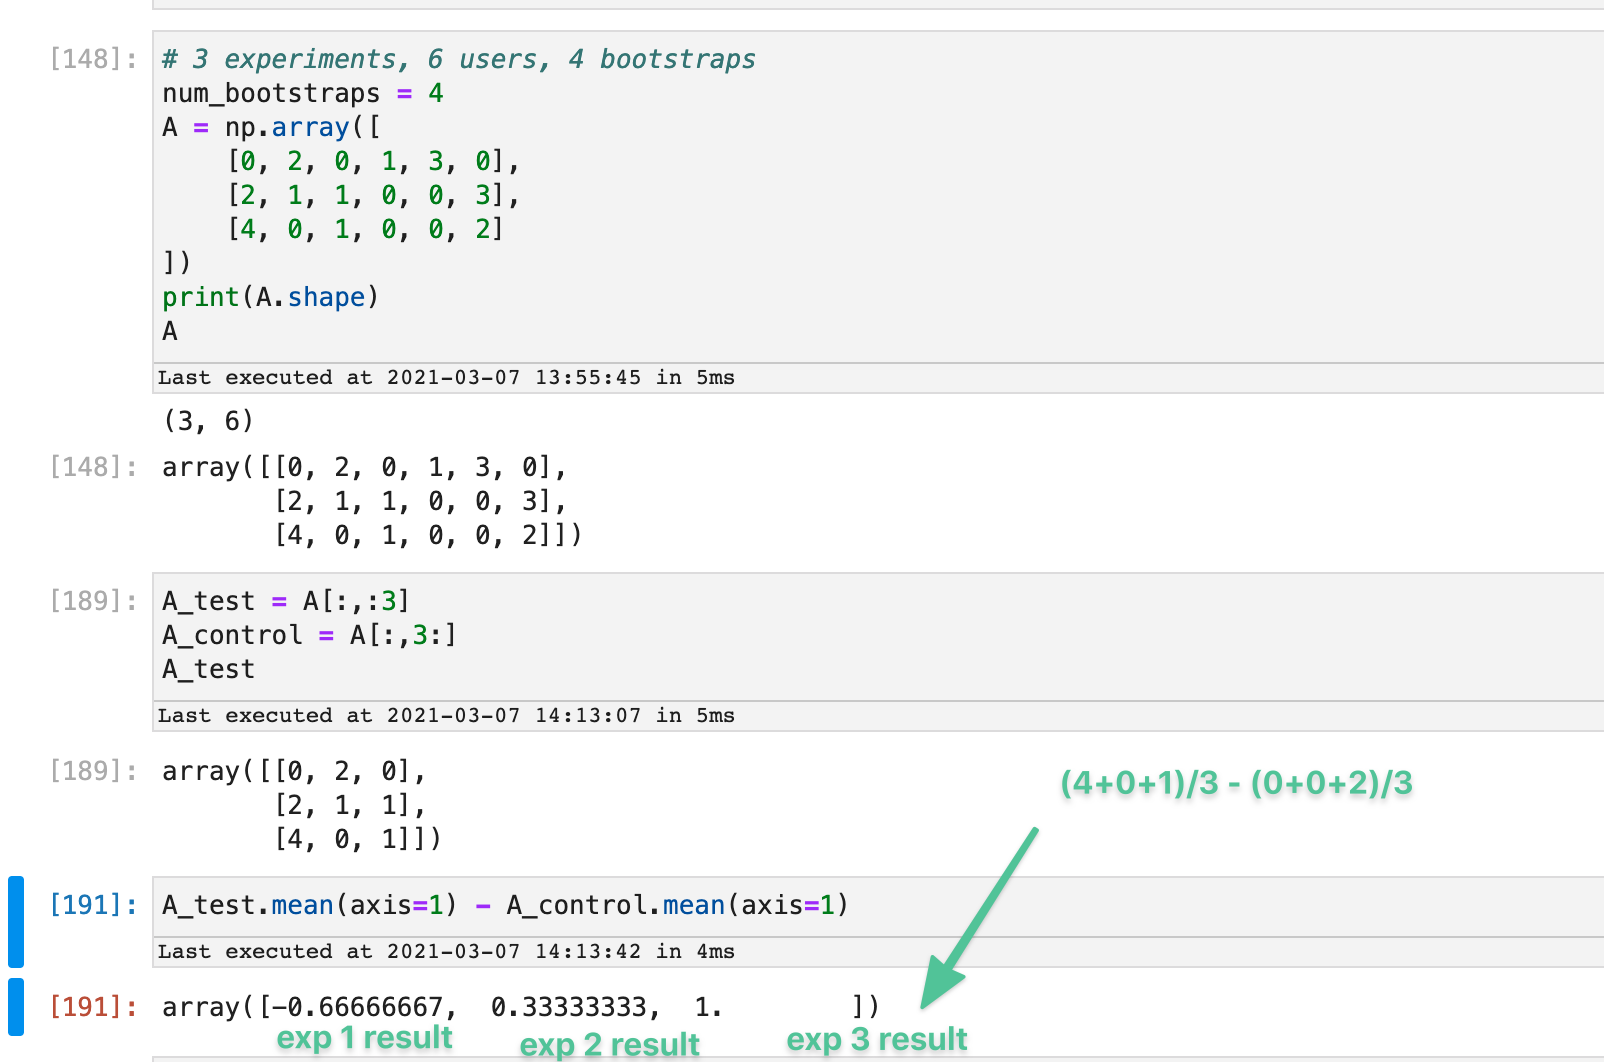

## Generate num_bootstrap copies of dataset, then shuffle users around in each bootstrap sample (with replacement)

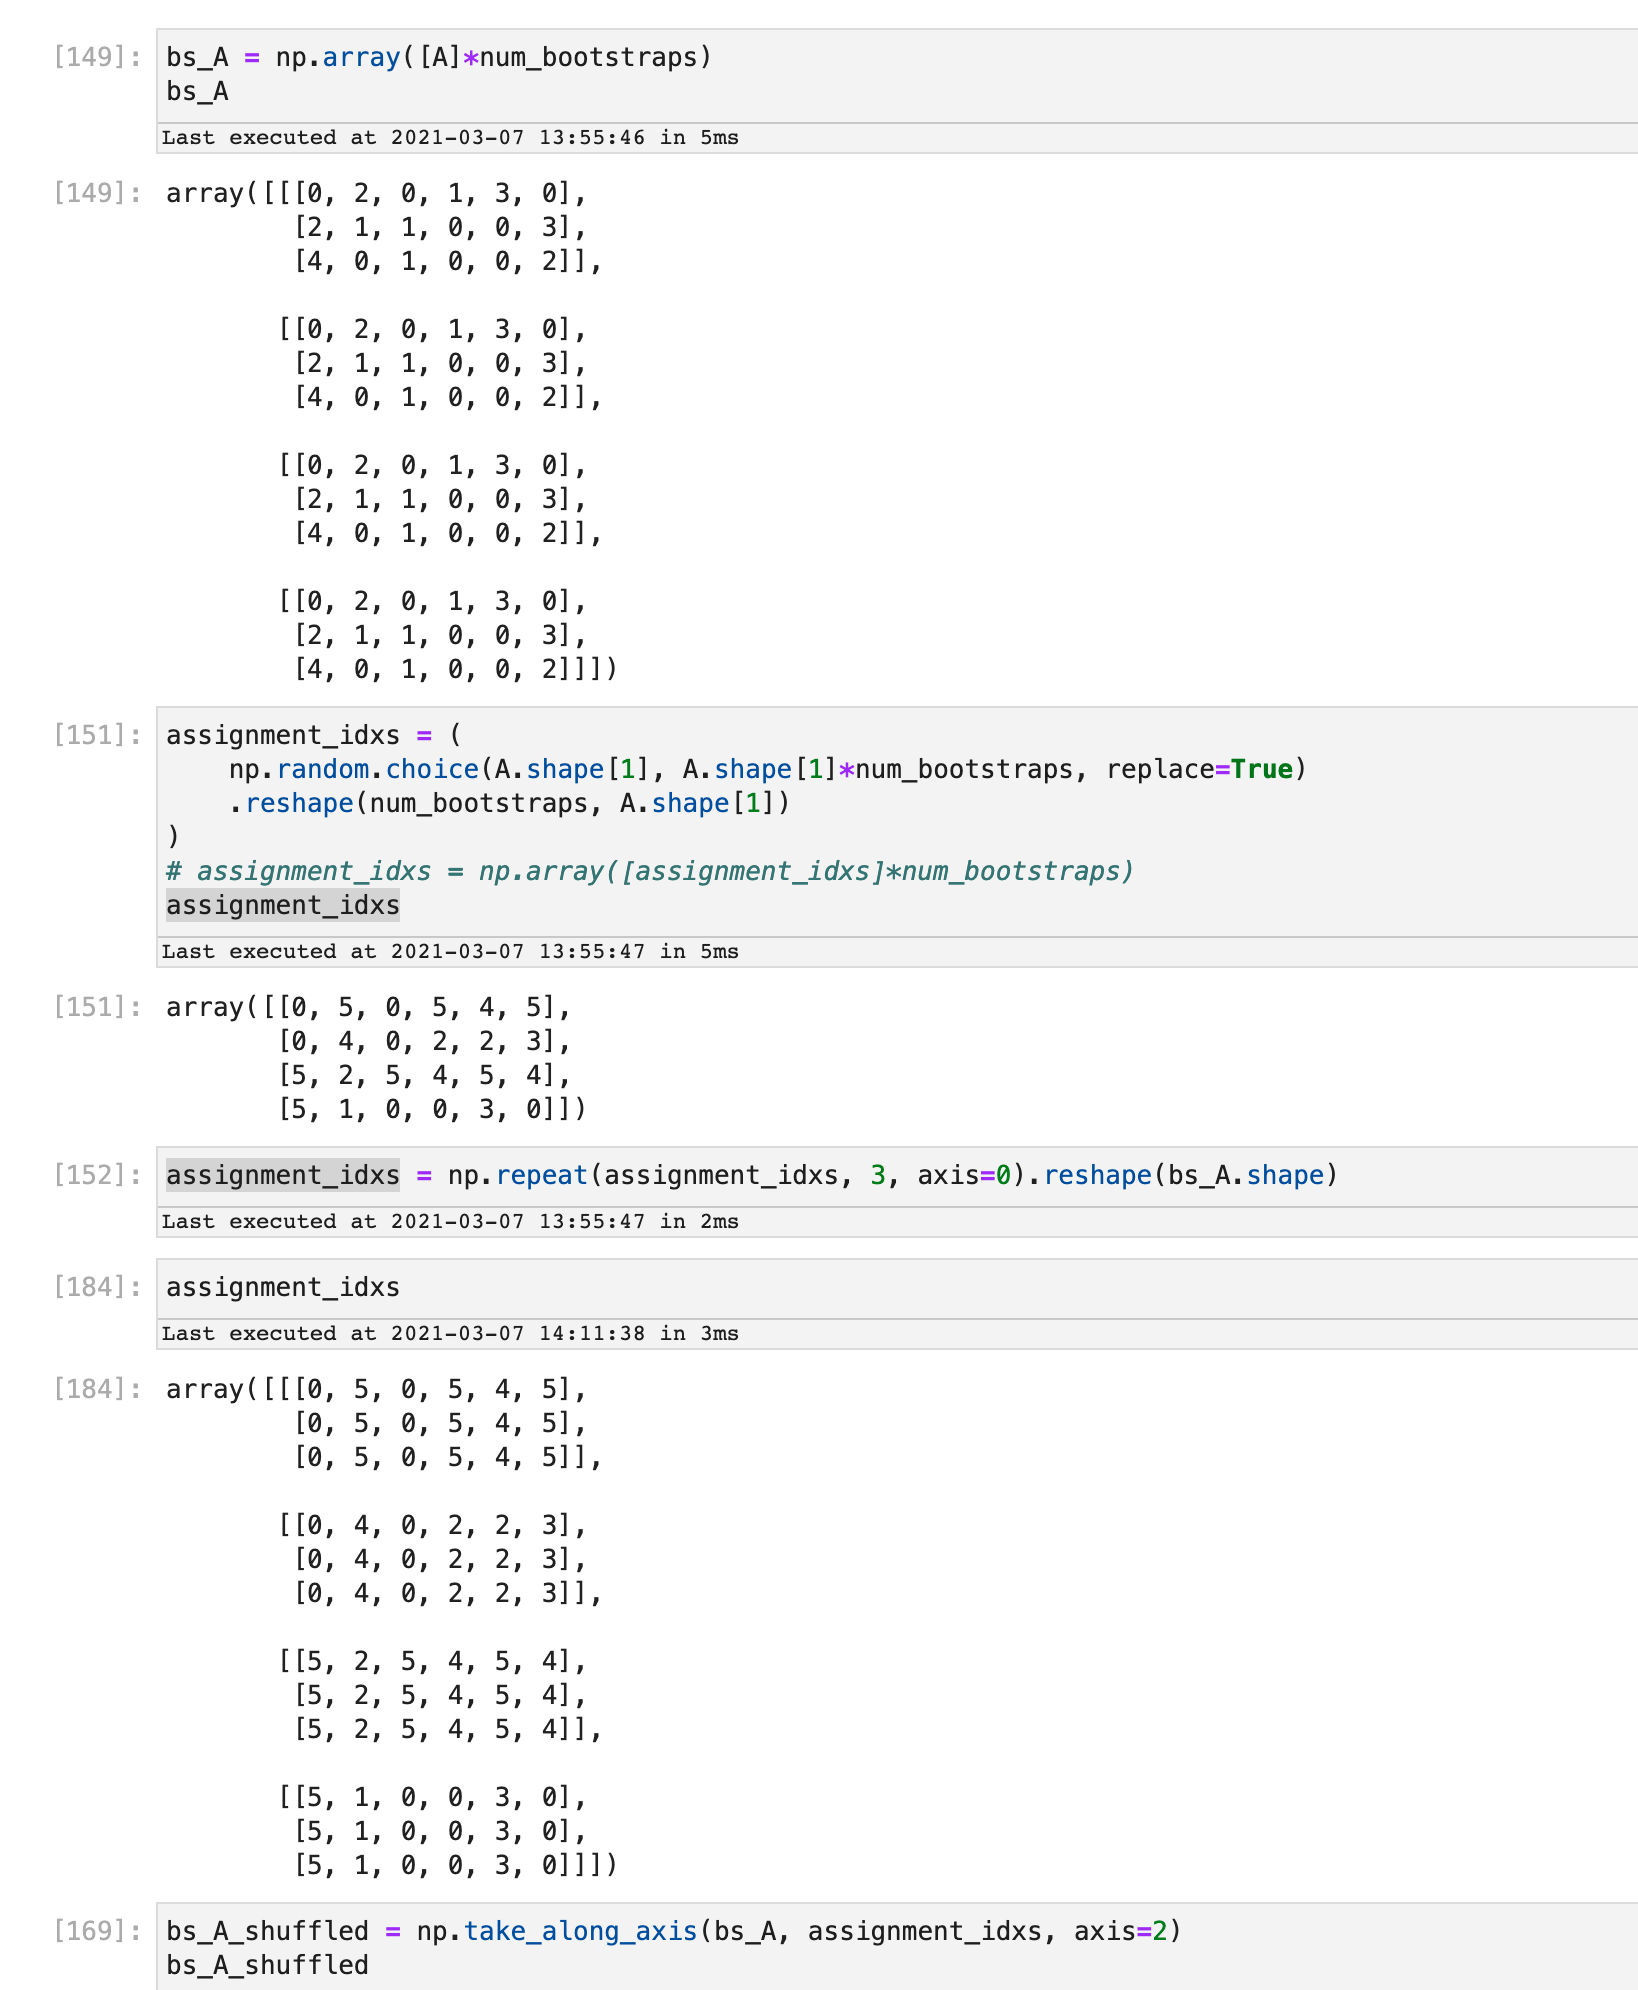

# Explanation of bootstrap_shuffled

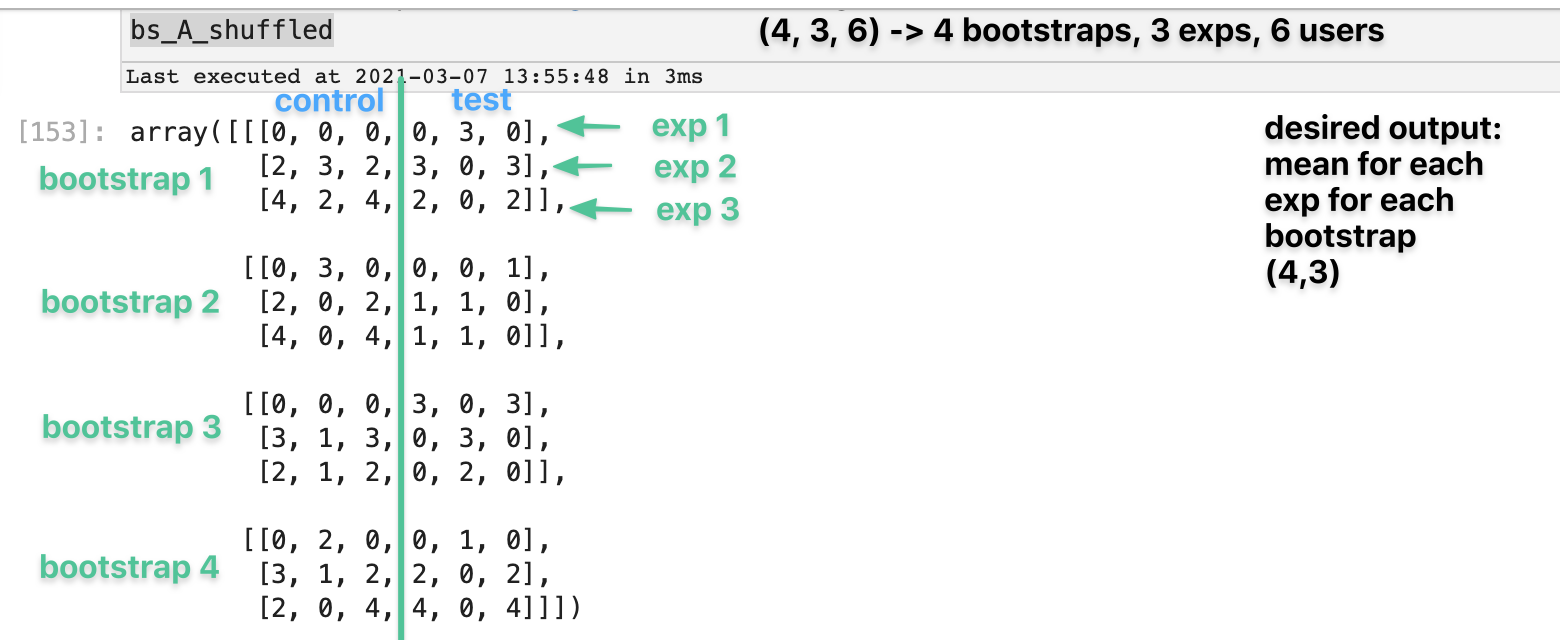

# Calculate ExP results for each bootstrap

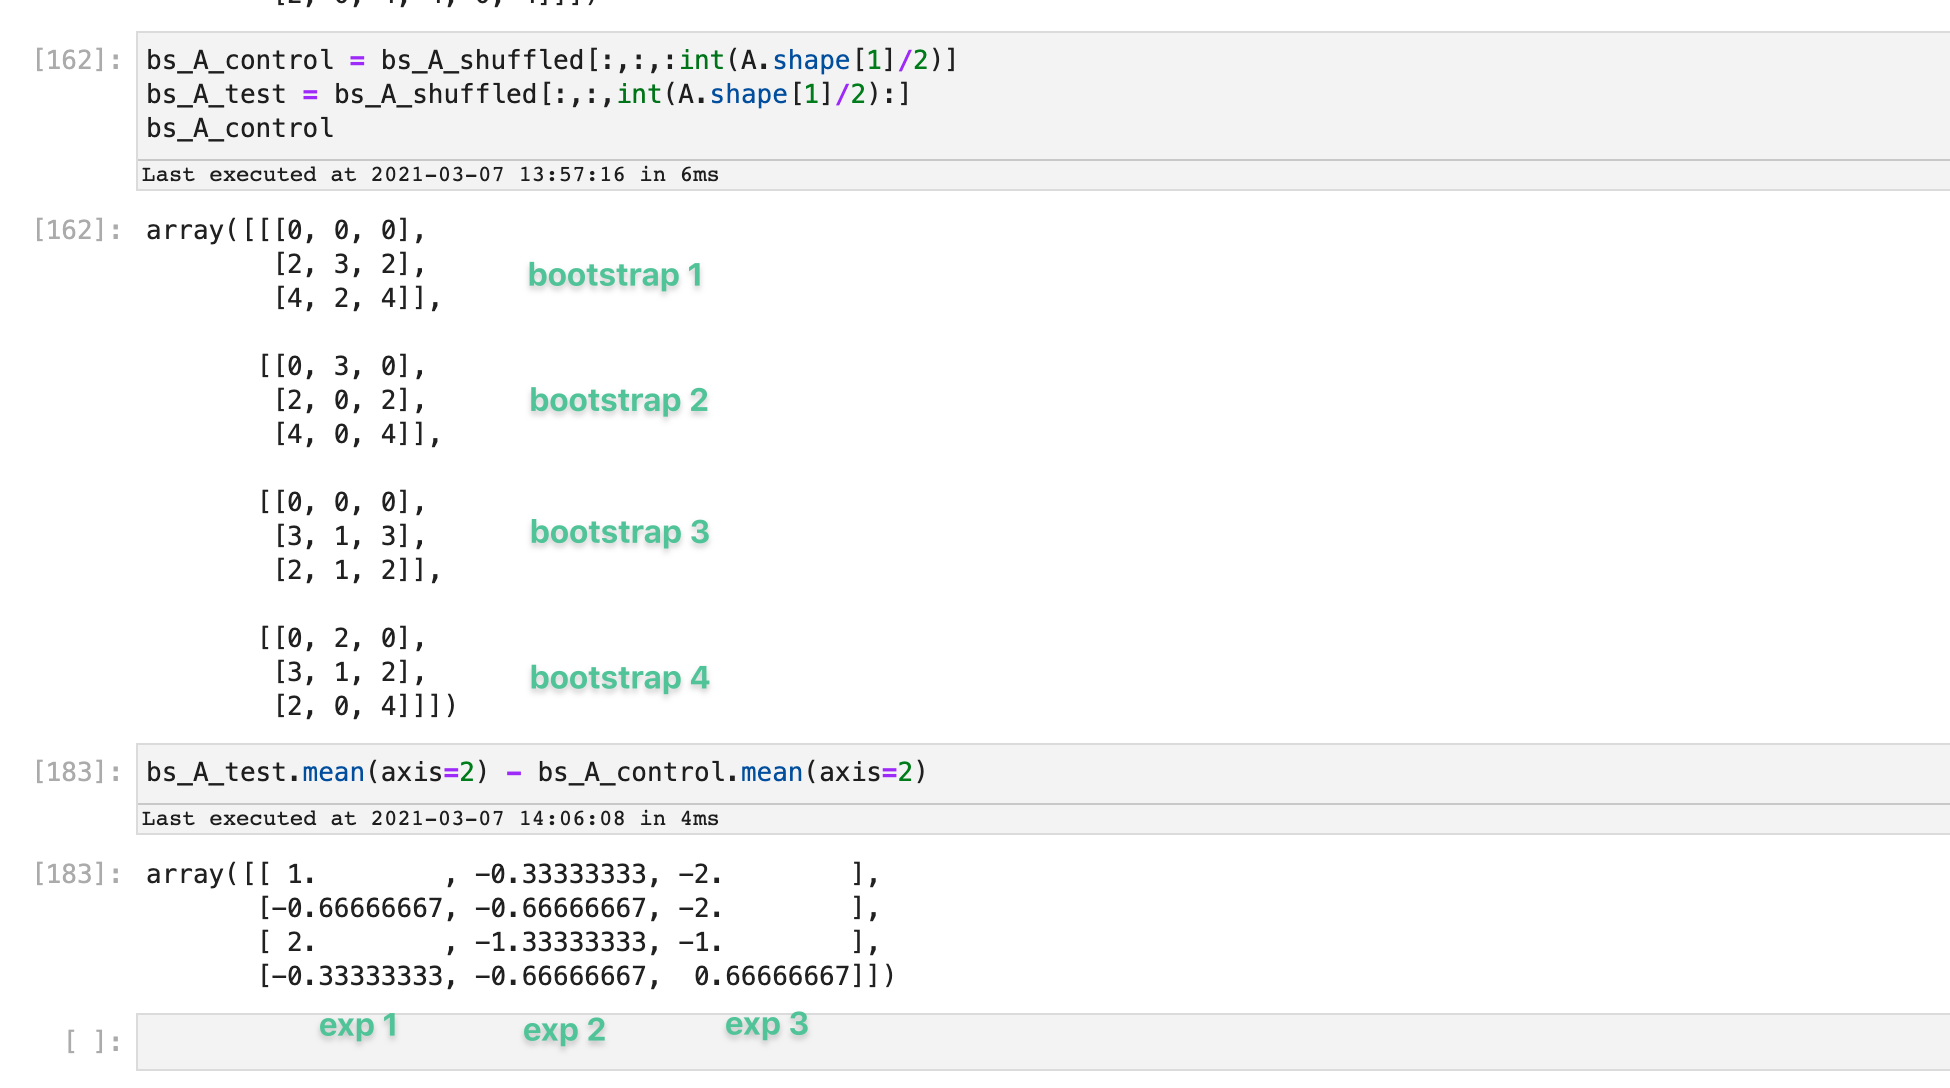

# Remaining steps

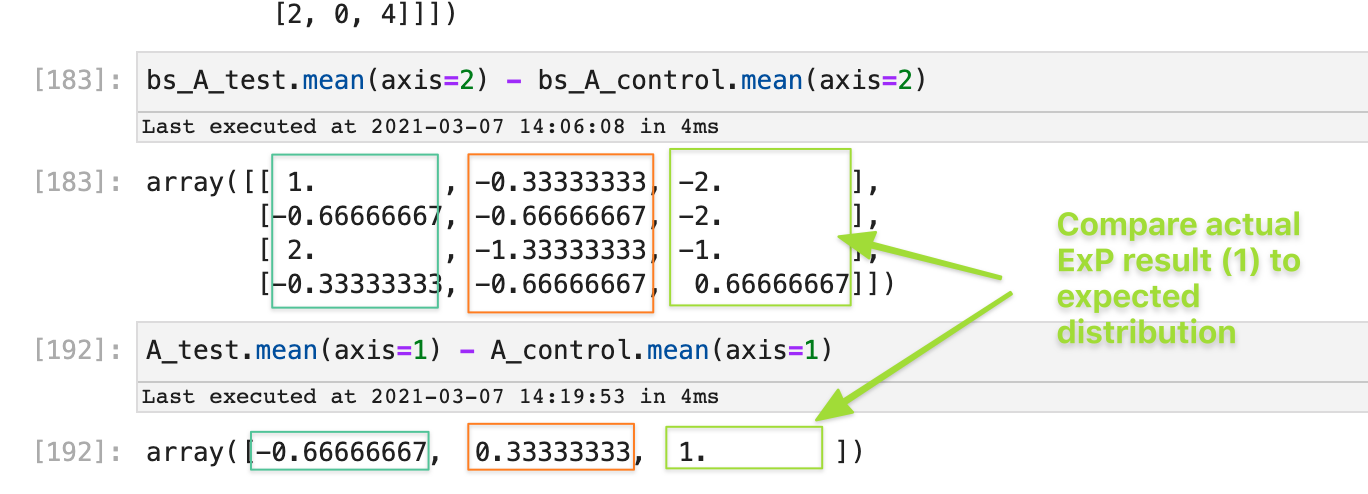